# OCR engine comparison

<img src="https://media.arxiv-vanity.com/render-output/6158804/images/fig_2_no_trademarks.png" alt="text to images" width="600" height="600">

In [1]:
import pandas as pd
import numpy as np
import random

from glob import glob
# from tqdm.notebook import tqdm
from tqdm import tqdm

import matplotlib.pyplot as plt
from PIL import Image
import cv2
import Levenshtein as Lv
from statistics import mean

plt.style.use('ggplot')

# Outline
1. Take a look at the data
2. Extract text from images:
    - pytesseract
    - easyocr
    - keras_ocr
3. Run on a few examples and compare the results

## About the data
TextOCR requires models to perform text-recognition on arbitrary shaped scene-text present on natural images. TextOCR provides ~1M high quality word annotations on TextVQA images allowing application of end-to-end reasoning on downstream tasks such as visual question answering or image captioning.

- 28,134 natural images from TextVQA
- 903,069 annotated scene-text words
- 32 words per image on average

In [2]:
annot = pd.read_parquet('train_val_images/annot.parquet')
imgs = pd.read_parquet('train_val_images/img.parquet')
img_fns = glob('train_val_images/train_images/*')

In [3]:
annot.head(5)

id          image_id                           bbox  \
0  a4ea732cd3d5948a_1  a4ea732cd3d5948a   [525.83, 3.4, 197.64, 33.94]   
1  a4ea732cd3d5948a_2  a4ea732cd3d5948a  [534.67, 64.68, 91.22, 38.19]   
2  a4ea732cd3d5948a_3  a4ea732cd3d5948a  [626.95, 63.62, 96.52, 31.82]   
3  a4ea732cd3d5948a_4  a4ea732cd3d5948a  [577.4, 141.87, 147.13, 43.1]   
4  a4ea732cd3d5948a_5  a4ea732cd3d5948a  [391.03, 163.9, 60.82, 38.65]   

   utf8_string                                             points     area  
0  Performance  [525.83, 3.4, 723.47, 7.29, 722.76, 36.99, 525...  6707.90  
1        Sport  [535.73, 64.68, 623.41, 67.51, 625.89, 102.87,...  3483.69  
2        Watch  [626.95, 63.62, 721.7, 63.62, 723.47, 95.44, 6...  3071.27  
3   ...period.  [580.02, 143.61, 724.53, 141.87, 723.66, 184.9...  6341.30  
4            .  [395.2, 163.9, 451.85, 191.94, 445.59, 202.55,...  2350.69

# Plot Example Images

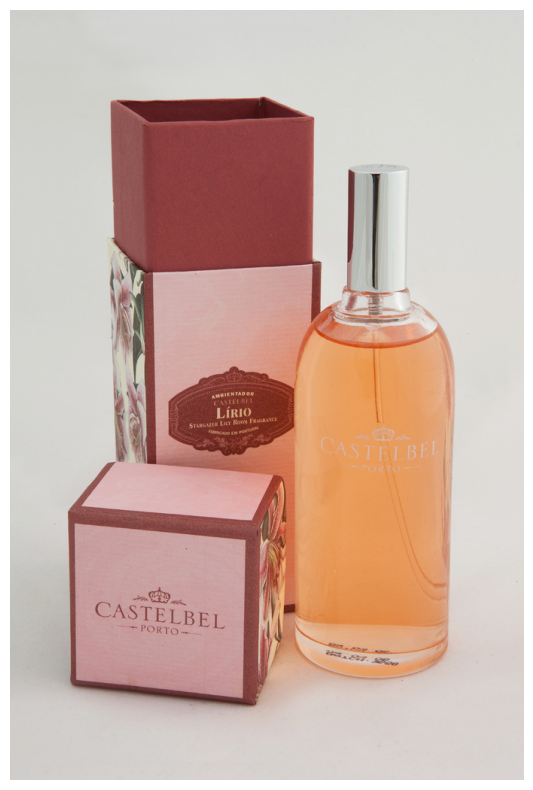

In [4]:
fig, ax = plt.subplots(figsize=(10, 10))
ax.imshow(plt.imread(img_fns[100]))
ax.axis('off')
plt.show()

In [5]:
image_id = img_fns[100].split('/')[-1].split('\\')[-1].split('.')[0]
annot[annot["image_id"] == image_id]

id          image_id  \
453742   0023199523656671_1  0023199523656671   
453743   0023199523656671_2  0023199523656671   
453744   0023199523656671_3  0023199523656671   
453745   0023199523656671_4  0023199523656671   
453746   0023199523656671_5  0023199523656671   
453747   0023199523656671_6  0023199523656671   
453748   0023199523656671_7  0023199523656671   
453749   0023199523656671_8  0023199523656671   
453750   0023199523656671_9  0023199523656671   
453751  0023199523656671_10  0023199523656671   
453752  0023199523656671_11  0023199523656671   
453753  0023199523656671_12  0023199523656671   
453754  0023199523656671_13  0023199523656671   
453755  0023199523656671_14  0023199523656671   
453756  0023199523656671_15  0023199523656671   
453757  0023199523656671_16  0023199523656671   
453758  0023199523656671_17  0023199523656671   
453759  0023199523656671_18  0023199523656671   
453760  0023199523656671_19  0023199523656671   
453761  0023199523656671_20  0023199523656671   
453762  0023199523656671_21  0023199523656671   
453763  0023199523656671_22  0023199523656671   
453764  0023199523656671_23  0023199523656671   

                                   bbox  utf8_string  \
453742   [266.38, 504.88, 59.06, 13.67]  AMBIENTADOR   
453743    [269.89, 514.17, 55.2, 13.32]    CASTELBEL   
453744   [273.39, 525.73, 48.02, 18.41]            .   
453745   [236.77, 546.24, 40.48, 10.86]    STARGAZER   
453746    [278.83, 544.66, 16.29, 8.94]         LILY   
453747    [296.18, 543.43, 19.97, 8.94]         ROOM   
453748    [318.26, 540.46, 37.68, 9.81]    FRAGTANCE   
453749     [262.18, 557.1, 30.49, 9.64]    FABRICADO   
453750     [293.37, 559.73, 9.99, 5.61]           EM   
453751    [303.36, 551.5, 28.39, 13.67]     PORTUGAL   
453752  [412.16, 566.21, 159.32, 34.45]    CASTELBEL   
453753   [466.73, 602.74, 52.26, 14.34]        PORTO   
453754  [112.12, 784.94, 175.45, 40.28]    CASTELBEL   
453755   [172.84, 816.68, 51.87, 15.56]        PORTO   
453756    [477.63, 861.0, 40.67, 13.28]            .   
453757    [482.46, 858.18, 23.56, 9.46]            .   
453758   [417.44, 851.94, 32.81, 12.68]            .   
453759   [418.24, 848.11, 23.56, 10.27]            .   
453760   [448.04, 857.77, 29.59, 10.47]            .   
453761    [451.86, 855.27, 23.76, 8.25]            .   
453762    [483.67, 849.52, 22.95, 7.65]            .   
453763   [450.05, 844.29, 27.78, 10.26]            .   
453764   [421.47, 839.05, 29.39, 12.69]            .   

                                                   points     area  
453742  [266.38, 508.91, 324.92, 504.88, 325.44, 514.5...   807.35  
453743  [269.89, 517.85, 325.09, 514.17, 325.09, 523.4...   735.26  
453744  [273.57, 526.96, 321.41, 525.73, 321.41, 541.6...   884.05  
453745  [236.77, 548.52, 276.9, 546.24, 277.25, 554.48...   439.61  
453746  [278.83, 545.19, 294.95, 544.66, 295.12, 553.0...   145.63  
453747  [296.18, 544.31, 315.8, 543.43, 316.15, 551.5,...   178.53  
453748  [318.26, 542.21, 355.94, 540.46, 355.94, 548.8...   369.64  
453749  [262.7, 557.1, 292.67, 559.21, 292.67, 566.74,...   293.92  
453750  [293.37, 559.73, 303.36, 559.73, 303.36, 565.1...    56.04  
453751  [303.36, 559.03, 330.53, 551.5, 331.75, 557.28...   388.09  
453752  [412.16, 566.44, 571.25, 566.21, 571.48, 600.6...  5488.57  
453753  [466.73, 602.74, 518.99, 602.74, 518.99, 616.6...   749.41  
453754  [112.12, 784.94, 287.57, 799.28, 287.57, 825.2...  7067.13  
453755  [173.15, 816.68, 224.71, 821.25, 224.1, 832.24...   807.10  
453756  [481.86, 861.0, 518.3, 866.63, 514.27, 874.28,...   540.10  
453757  [486.89, 858.18, 506.02, 861.4, 501.99, 867.64...   222.88  
453758  [419.25, 851.94, 450.25, 859.18, 448.04, 864.6...   416.03  
453759  [420.66, 848.11, 441.8, 853.55, 439.99, 858.38...   241.96  
453760  [450.05, 857.77, 477.63, 862.2, 475.62, 868.24...   309.81  
453761  [453.88, 855.27, 475.62, 858.69, 474.21, 863.5...   196.02  
453762  [484.07, 849.52, 506.42, 850.33, 506.62, 857.1

## Display for first 25 images

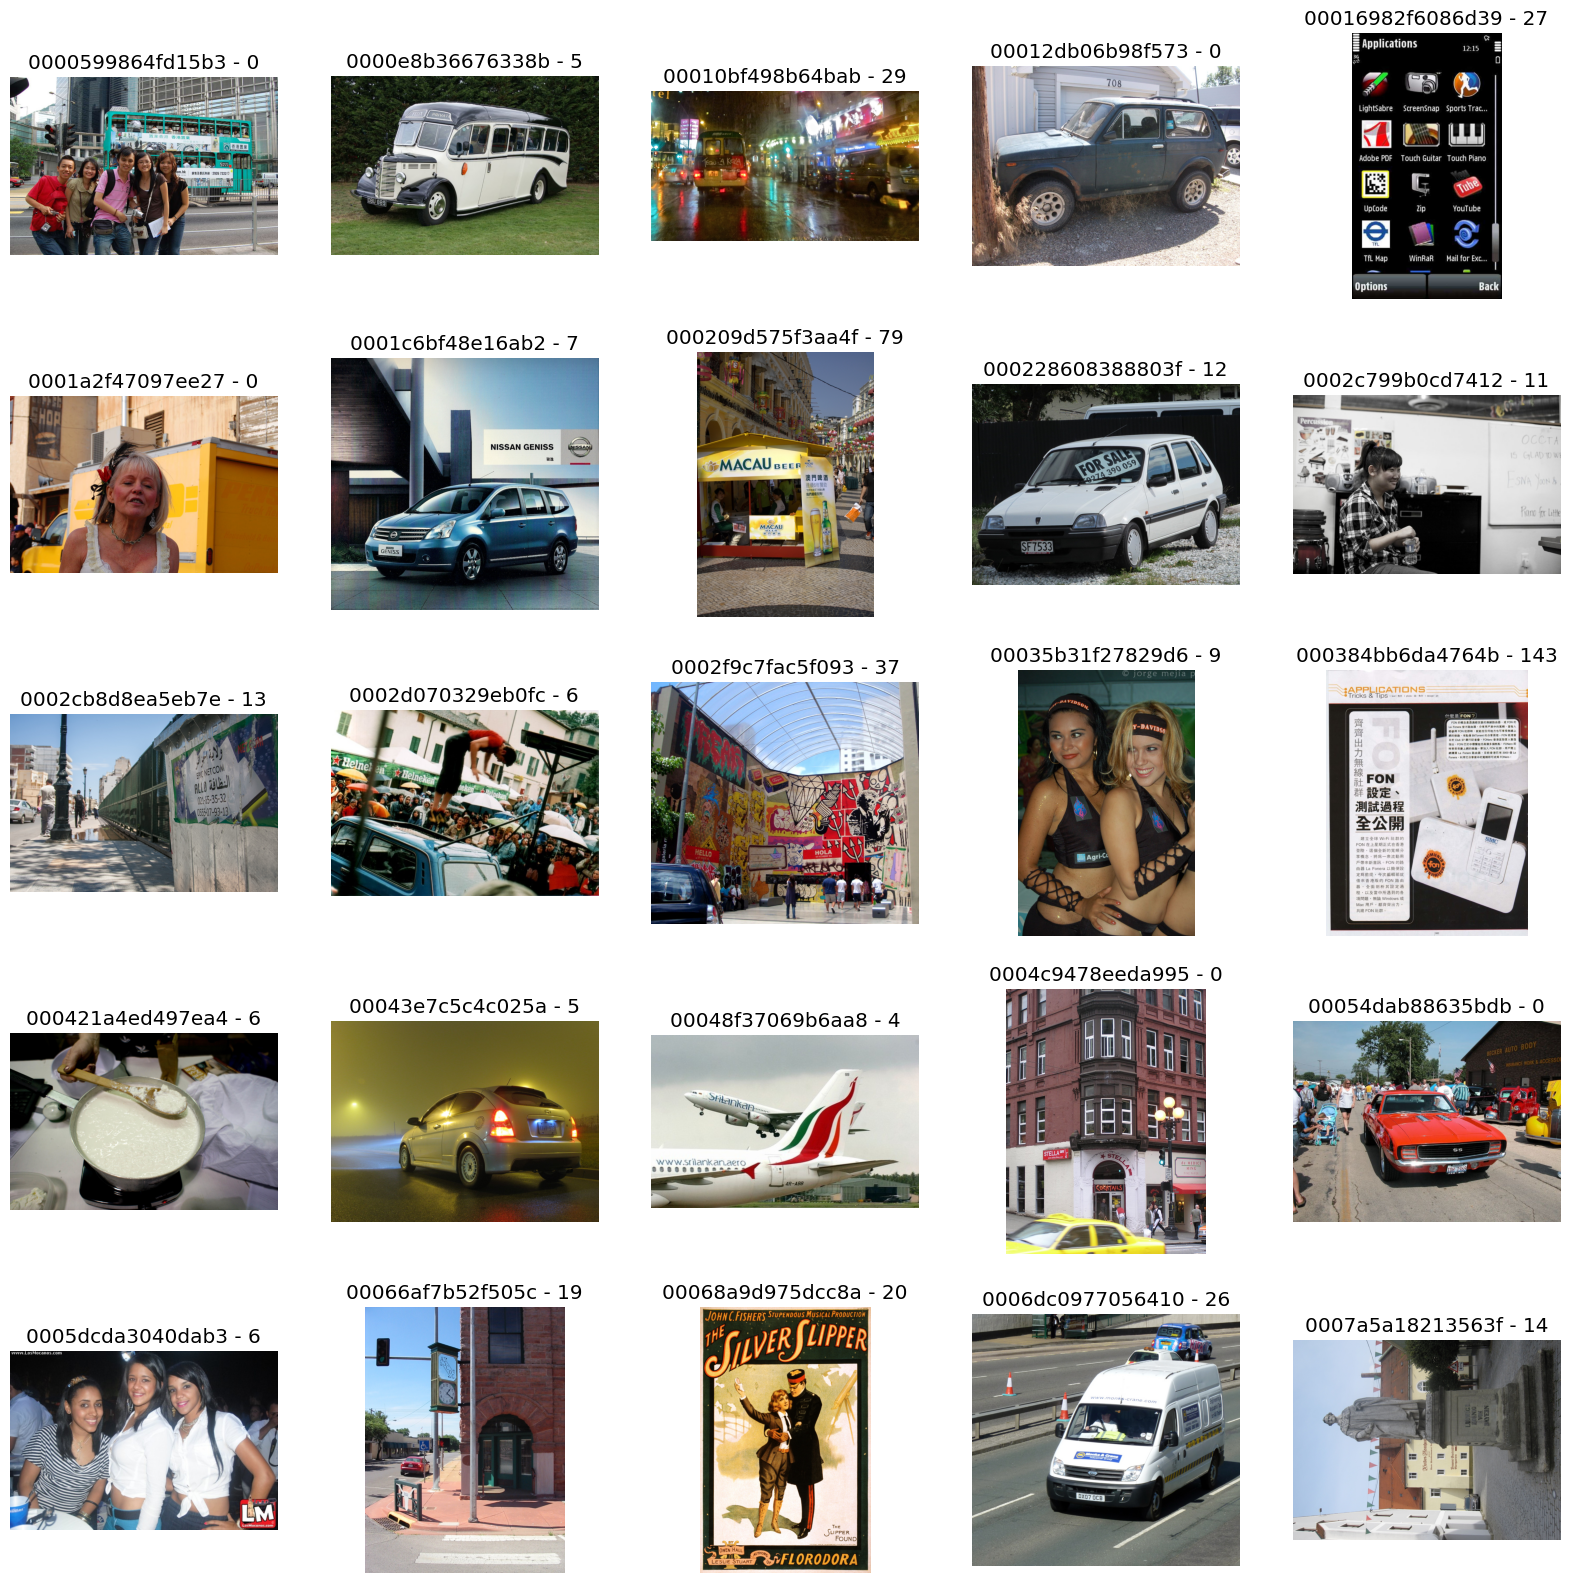

In [6]:
fig, axs = plt.subplots(5, 5, figsize=(20, 20))
axs = axs.flatten()
for i in range(25):
    axs[i].imshow(plt.imread(img_fns[i]))
    axs[i].axis('off')
    image_id = img_fns[i].split('/')[-1].split('\\')[-1].split('.')[0]
    n_annot = len(annot.query('image_id == @image_id'))
    axs[i].set_title(f'{image_id} - {n_annot}')
plt.show()

***

# Comparison method:
Because the bounding box can be slightly different depending on the OCR engine, it would not be possible to to let the engines detect text, and compare the result to the ground truth by comparing it with the text in the bounding boxes provided by the dataset. Since words can repeat in a single picture, looking if a string is included in the annotations could also lead to false positives. 
To avoid these problems, the bounding boxes described by the dataset for the text will be used by the OCR engines as Regions Of Interet (ROIs). The resulting detected string can then be compared one-to-one to the base truth for this area of the picture.
Working on ROIs rather than the whole picture can improve the accuracy of the detection and recognition of characters by reducing noise, leading to skewed comparison results, but since the use cases of this thesis will also make use of ROIs, this method is here appropriate to choose the best engine for our uses.

### Statistical tests:
Test on 20 randomly chosen pictures from dataset
1. Word Error Rate (WER)
2. Character Error Rate (CER) -> Levenshtein distance = Minimum number of steps (deletion, insertion, replacement) to get from one string to another

In [7]:
sample_size = 100
sample_idxs = random.sample(range(0, len(img_fns)), sample_size)

class Img:
    def __init__(self, idx):
        self.image = cv2.imread(img_fns[idx])
        self.image_id = img_fns[idx].split('/')[-1].split('\\')[-1].split('.')[0]
        self.annotations = annot.query('image_id == @self.image_id')

sample = [Img(idx) for idx in sample_idxs]


In [8]:
sample[0].annotations

id          image_id  \
643177   0c8c19243eae8e6e_1  0c8c19243eae8e6e   
643178   0c8c19243eae8e6e_2  0c8c19243eae8e6e   
643179   0c8c19243eae8e6e_3  0c8c19243eae8e6e   
643180   0c8c19243eae8e6e_4  0c8c19243eae8e6e   
643181   0c8c19243eae8e6e_5  0c8c19243eae8e6e   
643182   0c8c19243eae8e6e_6  0c8c19243eae8e6e   
643183   0c8c19243eae8e6e_7  0c8c19243eae8e6e   
643184   0c8c19243eae8e6e_8  0c8c19243eae8e6e   
643185   0c8c19243eae8e6e_9  0c8c19243eae8e6e   
643186  0c8c19243eae8e6e_10  0c8c19243eae8e6e   

                                   bbox  utf8_string  \
643177    [124.65, 794.8, 96.84, 42.72]     Anthilia   
643178   [113.26, 812.6, 118.92, 47.71]  DONNAFUGATA   
643179   [324.75, 760.62, 81.89, 28.48]        NORDA   
643180   [341.13, 587.58, 69.07, 17.09]     NATURALY   
643181   [330.36, 785.21, 17.05, 10.23]            .   
643182     [345.86, 786.14, 30.37, 9.3]            .   
643183     [376.54, 785.83, 22.01, 9.3]            .   
643184  [516.03, 647.82, 114.52, 38.75]       SEDARA   
643185    [513.94, 815.6, 88.79, 27.25]  DONNAFUGATA   
643186     [589.74, -0.08, 21.36, 34.9]            A   

                                                   points     area  
643177  [125.36, 809.75, 220.78, 794.8, 221.49, 823.28...  4137.00  
643178  [113.26, 828.26, 232.18, 812.6, 231.46, 842.51...  5673.67  
643179  [325.46, 760.62, 405.92, 760.62, 406.64, 789.1...  2332.23  
643180  [342.55, 588.29, 410.2, 587.58, 410.2, 604.67,...  1180.41  
643181  [330.67, 785.21, 347.41, 787.38, 347.1, 795.44...   174.42  
643182  [345.86, 786.14, 376.23, 787.38, 376.23, 795.1...   282.44  
643183  [376.85, 787.07, 398.24, 785.83, 398.55, 793.2...   204.69  
643184  [516.03, 647.82, 630.55, 648.4, 629.97, 686.57...  4437.65  
643185  [513.94, 815.6, 602.26, 824.53, 602.73, 842.85...  2419.53  
643186  [590.45, -0.08, 609.68, 0.64, 611.1, 34.1, 589...   745.46

# Engine 1: pytesseract

In [9]:
from pytesseract import pytesseract
pytesseract.tesseract_cmd = r'C:\Program Files\Tesseract-OCR\tesseract'

In [10]:
with open('engine_acc_results/pytesseract_accuracy_test.txt', 'w', encoding="utf-8") as f:
    f.write(f"Pytesseract inaccurate results:\n")

total_accurate = 0
total_annot = 0
total_char = 0
lv_distances = []

for img in sample[:20]:

    with open('engine_acc_results/pytesseract_accuracy_test.txt', 'a', encoding="utf-8") as f:
        f.write(f"Image {img.image_id}:\n")

    img_accurate = 0

    for _, row in img.annotations.iterrows():
        
        # Pass over single dot texts
        if row['utf8_string'] == ".":
            continue
        
        total_annot += 1

        # Pass ROI to engine
        roi = [int(x) for x in row['bbox']]
        roi_img = img.image[roi[1]:roi[1]+roi[3], roi[0]:roi[0]+roi[2]]
        result = pytesseract.image_to_string(roi_img)

        # Get Levenshtein distance
        lv_distance = Lv.distance(row['utf8_string'].lower(), result.lower())
        lv_distances.append(lv_distance)
        
        # Check if word recognition is correct
        if result.lower() == row['utf8_string'].lower():
            img_accurate += 1
        else:
            with open('engine_acc_results/pytesseract_accuracy_test.txt', 'a', encoding="utf-8") as f:
                f.write(f"Expected: {row['utf8_string'].lower()}, actual: {result.lower()}, lv_distance: {lv_distance}\n")
            
        total_accurate += img_accurate
        total_char += len(row['utf8_string'])

    with open('engine_acc_results/pytesseract_accuracy_test.txt', 'a', encoding="utf-8") as f:
        f.write("\n")
    
    # print(f"Image word accuracy = {img_accurate}/{img_annot}")

In [11]:
print(f"Total word accuracy = {total_accurate}/{total_annot}")
print(f"Sum of Levenshtein distances / Total number of characters = {sum(lv_distances)} / {total_char}")

Total word accuracy = 0/449
Sum of Levenshtein distances / Total number of characters = 1880 / 2274


# Method 2: easyocr

In [12]:
import easyocr
reader = easyocr.Reader(['en'], gpu = True)

CUDA not available - defaulting to CPU. Note: This module is much faster with a GPU.


In [13]:
with open('engine_acc_results/easy_accuracy_test.txt', 'w', encoding="utf-8") as f:
    f.write(f"EasyOCR inaccurate results:\n")

total_accurate = 0
total_annot = 0
total_char = 0
lv_distances = []

for img in sample[:20]:

    with open('engine_acc_results/easy_accuracy_test.txt', 'a', encoding="utf-8") as f:
        f.write(f"Image {img.image_id}:\n")

    # img_accurate = 0

    for _, row in img.annotations.iterrows():
        
        # Pass over single dot strings
        if row['utf8_string'] == ".":
            continue
    
        total_annot += 1

        # Pass ROI to engine
        roi = [int(x) for x in row['bbox']]
        roi_img = img.image[roi[1]:roi[1]+roi[3], roi[0]:roi[0]+roi[2]]
        result = reader.readtext(roi_img)
        result_df = pd.DataFrame(result, columns=['bbox','text','conf'])
        result = ''.join(result_df['text'])
        
        # Get Levenshtein distance
        lv_distance = Lv.distance(row['utf8_string'].lower(), result.lower())
        lv_distances.append(lv_distance)
        
        # Check if word recognition is correct
        if result.lower() == row['utf8_string'].lower():
            # img_accurate += 1
            total_accurate += 1
        else:
            with open('engine_acc_results/easy_accuracy_test.txt', 'a', encoding="utf-8") as f:
                f.write(f"Expected: {row['utf8_string'].lower()}, actual: {result.lower()}, lv_distance: {lv_distance}\n")

        # total_accurate += img_accurate
        total_char += len(row['utf8_string'])

    with open('engine_acc_results/easy_accuracy_test.txt', 'a', encoding="utf-8") as f:
        f.write("\n")
    
    # print(f"Image word accuracy = {img_accurate}/{img_annot}")

In [14]:
print(f"Total word accuracy = {total_accurate}/{total_annot}")
print(f"Sum of Levenshtein distances / Total number of characters = {sum(lv_distances)} / {total_char}")

Total word accuracy = 51/449
Sum of Levenshtein distances / Total number of characters = 1669 / 2274


# Method 3: keras_ocr

In [33]:
import keras_ocr

pipeline = keras_ocr.pipeline.Pipeline()

Looking for C:\Users\diego\.keras-ocr\craft_mlt_25k.h5
Looking for C:\Users\diego\.keras-ocr\crnn_kurapan.h5


In [36]:
with open('engine_acc_results/keras_accuracy_test.txt', 'w', encoding="utf-8") as f:
    f.write(f"Keras OCR inaccurate results:\n")

total_accurate = 0
total_annot = 0
total_char = 0
lv_distances = []

for img in sample[:20]:

    with open('engine_acc_results/keras_accuracy_test.txt', 'a', encoding="utf-8") as f:
        f.write(f"Image {img.image_id}:\n")

    # img_accurate = 0

    for _, row in img.annotations.iterrows():
        
        # Pass over single dot strings
        if row['utf8_string'] == ".":
            continue
    
        total_annot += 1

        # Pass ROI to engine
        roi = [int(x) for x in row['bbox']]
        roi_img = img.image[roi[1]:roi[1]+roi[3], roi[0]:roi[0]+roi[2]]
        try:
            result = pipeline.recognize([roi_img])
        except:
            print(f"ROI image dimensions: {roi_img.shape}")
            continue
        # print(result[0])
        result_df = pd.DataFrame(result[0], columns=['text','bbox'])
        result = ''.join(result_df['text'])
        # print(result)
        
        # Get Levenshtein distance
        lv_distance = Lv.distance(row['utf8_string'].lower(), result.lower())
        lv_distances.append(lv_distance)
        
        # Check if word recognition is correct
        if result.lower() == row['utf8_string'].lower():
            # img_accurate += 1
            total_accurate += 1
        else:
            with open('engine_acc_results/keras_accuracy_test.txt', 'a', encoding="utf-8") as f:
                f.write(f"Expected: {row['utf8_string'].lower()}, actual: {result.lower()}, lv_distance: {lv_distance}\n")

        # total_accurate += img_accurate
        total_char += len(row['utf8_string'])

    with open('engine_acc_results/keras_accuracy_test.txt', 'a', encoding="utf-8") as f:
        f.write("\n")
    
    # print(f"Image word accuracy = {img_accurate}/{img_annot}")

1/1 [==============================] - 0s 99ms/step
ROI image dimensions: (15, 6, 3)
1/1 [==============================] - 0s 447ms/step
ROI image dimensions: (12, 7, 3)
1/1 [==============================] - 0s 139ms/step
ROI image dimensions: (10, 7, 3)
1/1 [==============================] - 0s 63ms/step
ROI image dimensions: (11, 7, 3)
1/1 [==============================] - 0s 63ms/step
ROI image dimensions: (8, 7, 3)
1/1 [==============================] - 0s 58ms/step
ROI image dimensions: (10, 7, 3)
1/1 [==============================] - 0s 58ms/step
ROI image dimensions: (10, 7, 3)
1/1 [==============================] - 0s 80ms/step
ROI image dimensions: (7, 7, 3)
1/1 [==============================] - 0s 75ms/step
ROI image dimensions: (11, 6, 3)
1/1 [==============================] - 0s 94ms/step


In [37]:
print(f"Total word accuracy = {total_accurate}/{total_annot}")
print(f"Sum of Levenshtein distances / Total number of characters = {sum(lv_distances)} / {total_char}")

Total word accuracy = 66/449
Sum of Levenshtein distances / Total number of characters = 1489 / 2264
